# Multimodal Hate Speech Classification and Cyberbullying Detection

This notebook implements a multimodal model combining image and text features for hate speech detection and cyberbullying classification.

## Data Preprocessing


### Load Annotations and Prepare Data

In [37]:
import json
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Embedding, LSTM, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
# Load the annotations
with open('./multimodal-hate-speech/MMHS150K_GT.json', 'r') as f:
    annotations = json.load(f)


In [38]:
# Convert the JSON dict to a DataFrame
data = []
for tweet_id, info in annotations.items():
    data.append({
        'tweet_id': tweet_id,
        'tweet_text': info['tweet_text'],
        'labels': info['labels'],
        'labels_str': info['labels_str']
    })

df = pd.DataFrame(data)

In [40]:
df.head()

,tweet_id,tweet_text,labels,labels_str
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]"
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]"
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]"
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]"
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]"


# Add Image Path and Create Majority Label

In [41]:

# Path to the image folder
image_folder = './multimodal-hate-speech/img_resized'

In [42]:
# Add image path column
df['image_path'] = df['tweet_id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))


In [43]:
# Define majority vote function for labels
from collections import Counter

def majority_vote(labels):
    label_count = Counter(labels)
    return label_count.most_common(1)[0][0]

In [44]:
# Apply majority vote to create a single label column
df['majority_label'] = df['labels'].apply(majority_vote)

label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

In [45]:
# Create a new column 'majority_label_str' with the string representation of the majority label
df['majority_label_str'] = df['majority_label'].map(label_mapping)


In [46]:
df.head()

,tweet_id,tweet_text,labels,labels_str,image_path,majority_label,majority_label_str
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]",./multimodal-hate-speech/img_resized/111467935...,4,Religion
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]",./multimodal-hate-speech/img_resized/106302004...,5,OtherHate
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]",./multimodal-hate-speech/img_resized/110892736...,0,NotHate
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]",./multimodal-hate-speech/img_resized/111455853...,0,NotHate
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]",./multimodal-hate-speech/img_resized/103525248...,1,Racist


# Text Preprocessing

In [47]:
# Preprocess text data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [48]:
# Apply text preprocessing
df['cleaned_text'] = df['tweet_text'].apply(preprocess_text)


# Train-Test Splitting and Sampling

In [49]:
# Check the group sizes
df['majority_label'].value_counts()

majority_label
0    116790
1     14183
5      8196
2      5375
3      4926
4       353
Name: count, dtype: int64

In [51]:
# Get the minimum group size
min_group_size = df['majority_label'].value_counts().min()

In [52]:
# Define maximum samples per label for training and testing
train_samples_per_label = 1500
test_samples_per_label = 250

In [53]:
# Sample up to 1500 rows per label for training
train_data = (
    df.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
    .reset_index(drop=True)
)

# Use up to 250 rows per label for testing
remaining_data = df.loc[~df.index.isin(train_data.index)]
test_data = (
    remaining_data.groupby('majority_label', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_state=42))
    .reset_index(drop=True)
)


/var/folders/rh/l_ty2sb11m5bljbbs4kxnzfh0000gn/T/ipykernel_18876/3425876492.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), train_samples_per_label), random_state=42))
/var/folders/rh/l_ty2sb11m5bljbbs4kxnzfh0000gn/T/ipykernel_18876/3425876492.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), test_samples_per_label), random_s

In [54]:
# Print the sizes of train and test sets
print("Training data size:", train_data.shape)
print("Testing data size:", test_data.shape)

Training data size: (7853, 8)
Testing data size: (1500, 8)


In [55]:
# Tokenize text
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])
X_train_text = pad_sequences(tokenizer.texts_to_sequences(train_data['cleaned_text']), maxlen=100)
X_test_text = pad_sequences(tokenizer.texts_to_sequences(test_data['cleaned_text']), maxlen=100)

In [56]:
# Load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    try:
        if not os.path.exists(img_path):
            return np.zeros((target_size[0], target_size[1], 3))
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0
        return img
    except Exception as e:
        return np.zeros((target_size[0], target_size[1], 3))

In [57]:
X_train_image = np.array([load_and_preprocess_image(path) for path in train_data['image_path']])
X_test_image = np.array([load_and_preprocess_image(path) for path in test_data['image_path']])

In [58]:
X_train_image.shape

(7853, 224, 224, 3)

In [59]:
# Labels
y_train = np.array(train_data['majority_label'])
y_test = np.array(test_data['majority_label'])

# Model Building: Multimodal Model

## Image Model

In [60]:
# Define image model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

image_input = Input(shape=(224, 224, 3))
x_image = base_model(image_input, training=False)
x_image = GlobalAveragePooling2D()(x_image)
x_image = Dense(256, activation='relu')(x_image)
x_image = Dropout(0.5)(x_image)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


## Text Model

In [61]:
# Define text model
text_input = Input(shape=(100,))
x_text = Embedding(input_dim=20000, output_dim=128, input_length=100)(text_input)
x_text = LSTM(128, return_sequences=False)(x_text)
x_text = Dense(128, activation='relu')(x_text)
x_text = Dropout(0.5)(x_text)

/Users/suryaanshrathinam/Desktop/2nd Semester/Big Data Analytics Technology/project/env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Combined Multimodal Model

In [62]:
# Combine image and text features
combined = Concatenate()([x_image, x_text])
x_combined = Dense(128, activation='relu')(combined)
x_combined = Dropout(0.5)(x_combined)
output = Dense(len(label_mapping), activation='softmax')(x_combined)

In [63]:
# Build model
multimodal_model = Model(inputs=[image_input, text_input], outputs=output)
multimodal_model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [64]:
# Print Model Summary
multimodal_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,406 (102.50 MB)

 Trainable params: 3,282,694 (12.52 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Training the Model

In [65]:
# Train the model
history = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=15,
    batch_size=32,
    verbose=1
)

Epoch 1/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 224s 898ms/step - accuracy: 0.1843 - loss: 1.9278 - val_accuracy: 0.1820 - val_loss: 1.8204
Epoch 2/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 219s 890ms/step - accuracy: 0.2015 - loss: 1.7469 - val_accuracy: 0.2860 - val_loss: 1.8371
Epoch 3/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 222s 904ms/step - accuracy: 0.2580 - loss: 1.6886 - val_accuracy: 0.4340 - val_loss: 1.5614
Epoch 4/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 211s 858ms/step - accuracy: 0.4667 - loss: 1.3933 - val_accuracy: 0.4993 - val_loss: 1.4366
Epoch 5/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 210s 854ms/step - accuracy: 0.5518 - loss: 1.2427 - val_accuracy: 0.5087 - val_loss: 1.3836
Epoch 6/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 226s 918ms/step - accuracy: 0.5797 - loss: 1.1818 - val_accuracy: 0.5093 - val_loss: 1.3618
Epoch 7/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 216s 878ms/step - accuracy: 0.6006 - loss: 1.1047 - val_accuracy: 0.5013 - val_loss: 1.3502
Epoch 8/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 216s 878ms/step - accuracy: 0.6358 -

In [66]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)


Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 216s 877ms/step - accuracy: 0.8157 - loss: 0.5724 - val_accuracy: 0.5013 - val_loss: 1.5775
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 211s 858ms/step - accuracy: 0.8358 - loss: 0.5224 - val_accuracy: 0.5040 - val_loss: 1.6169
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 218s 885ms/step - accuracy: 0.8316 - loss: 0.5356 - val_accuracy: 0.5207 - val_loss: 1.5765
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 210s 855ms/step - accuracy: 0.8547 - loss: 0.4769 - val_accuracy: 0.5260 - val_loss: 1.6556
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 216s 879ms/step - accuracy: 0.8576 - loss: 0.4665 - val_accuracy: 0.5287 - val_loss: 1.7215


In [67]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [68]:
history0 = multimodal_model.fit(
    [X_train_image, X_train_text], y_train,
    validation_data=([X_test_image, X_test_text], y_test),
    epochs=5,
    batch_size=32,
    verbose=1
)

Epoch 1/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 222s 902ms/step - accuracy: 0.8685 - loss: 0.4276 - val_accuracy: 0.5327 - val_loss: 1.7729
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 223s 905ms/step - accuracy: 0.8673 - loss: 0.4224 - val_accuracy: 0.5507 - val_loss: 1.7394
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 222s 904ms/step - accuracy: 0.8776 - loss: 0.4113 - val_accuracy: 0.5373 - val_loss: 1.8141
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 230s 937ms/step - accuracy: 0.8924 - loss: 0.3654 - val_accuracy: 0.5567 - val_loss: 1.9210
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 229s 933ms/step - accuracy: 0.8956 - loss: 0.3738 - val_accuracy: 0.5700 - val_loss: 1.8697


In [69]:
# Append additional history to the existing one
history.history['loss'] += history0.history['loss']
history.history['val_loss'] += history0.history['val_loss']
history.history['accuracy'] += history0.history['accuracy']
history.history['val_accuracy'] += history0.history['val_accuracy']

In [70]:
# Save the entire binary model
multimodal_model.save('multimodel_model.h5') 

In [71]:
# Evaluate the model
loss, accuracy = multimodal_model.evaluate([X_test_image, X_test_text], y_test, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 692ms/step - accuracy: 0.4434 - loss: 2.2905
Test Accuracy: 57.00%


# Binary Classification for Cyberbullying

## Modify and Retrain Model

In [72]:
# Map the labels to "cyberbully" or "not" based on 'majority_label_str' column
hate_labels = ['Racist', 'Sexist', 'Homophobe', 'Religion', 'OtherHate']

In [73]:
# Create a new binary label column based on whether the tweet belongs to hate speech
df['binary_label'] = df['majority_label_str'].apply(lambda x: 'cyberbully' if any(label in x for label in hate_labels) else 'not')


In [74]:
df.rename(columns={'binary_label': 'binary_label_str'}, inplace=True)

In [75]:
df['binary_label'] = df['binary_label_str'].apply(lambda x: 1 if x == 'cyberbully' else 0)

In [76]:
df.head()

,tweet_id,tweet_text,labels,labels_str,image_path,majority_label,majority_label_str,cleaned_text,binary_label_str,binary_label
0,1114679353714016256,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,"[4, 1, 3]","[Religion, Racist, Homophobe]",./multimodal-hate-speech/img_resized/111467935...,4,Religion,nigga,cyberbully,1
1,1063020048816660480,My horses are retarded https://t.co/HYhqc6d5WN,"[5, 5, 5]","[OtherHate, OtherHate, OtherHate]",./multimodal-hate-speech/img_resized/106302004...,5,OtherHate,my horses are retarded,cyberbully,1
2,1108927368075374593,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,"[0, 0, 0]","[NotHate, NotHate, NotHate]",./multimodal-hate-speech/img_resized/110892736...,0,NotHate,nigga on ma momma youngboy be spitting real sh...,not,0
3,1114558534635618305,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,"[1, 0, 0]","[Racist, NotHate, NotHate]",./multimodal-hate-speech/img_resized/111455853...,0,NotHate,rt xxsugvngxx i ran into this holy nigga today,not,0
4,1035252480215592966,“EVERYbody calling you Nigger now!” https://t....,"[1, 0, 1]","[Racist, NotHate, Racist]",./multimodal-hate-speech/img_resized/103525248...,1,Racist,everybody calling you nigger now,cyberbully,1


In [ ]:
# from sklearn.utils import shuffle

In [77]:
def balance_classes(df, label_col, n_samples, random_state=42):
    np.random.seed(random_state)
    
    # Separate classes
    class_0 = df[df[label_col] == 0]
    class_1 = df[df[label_col] == 1]

    # Sample from each class
    class_0_sampled = class_0.sample(n=n_samples, random_state=random_state)
    class_1_sampled = class_1.sample(n=n_samples, random_state=random_state)

    # Concatenate and shuffle using numpy
    balanced_df = pd.concat([class_0_sampled, class_1_sampled])
    shuffled_indices = np.random.permutation(len(balanced_df))
    balanced_df = balanced_df.iloc[shuffled_indices].reset_index(drop=True)

    return balanced_df

In [78]:
# Create balanced datasets
balanced_df = balance_classes(df, 'binary_label', 4000)
balanced_df1 = balance_classes(df, 'binary_label', 500)

In [79]:
# Extract the features (text and images) and labels for train
X_binary_text_processed = pad_sequences(tokenizer.texts_to_sequences(balanced_df['cleaned_text']), maxlen=100)
X_binary_image_processed = np.array([load_and_preprocess_image(path) for path in balanced_df['image_path']])


In [80]:
y_binary = balanced_df['binary_label']

In [81]:
y_binary.shape

(8000,)

In [82]:
# Extract the features (text and images) and labels for text
X_test_binary_text_processed = pad_sequences(tokenizer.texts_to_sequences(balanced_df1['cleaned_text']), maxlen=100)
X_text_binary_image_processed = np.array([load_and_preprocess_image(path) for path in balanced_df1['image_path']])


In [83]:
y_test_binary = balanced_df1['binary_label']

In [84]:
y_test_binary.shape

(1000,)

In [85]:
X_binary_image_processed.shape

(8000, 224, 224, 3)

In [86]:
X_text_binary_image_processed.shape

(1000, 224, 224, 3)

In [87]:
from tensorflow.keras import layers, models

# Freeze all layers except the final one
for layer in multimodal_model.layers[:-1]:
    layer.trainable = False

# Add a new final layer for binary classification
binary_output = layers.Dense(1, activation='sigmoid')(multimodal_model.output)

# Create the binary model by combining the original multimodal model and the new final layer
binary_model = models.Model(inputs=multimodal_model.input, outputs=binary_output)

# Compile the binary model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [88]:
binary_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 128)  │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 6)         │        774 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          7 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,870,413 (102.50 MB)

 Trainable params: 781 (3.05 KB)

 Non-trainable params: 26,869,632 (102.50 MB)

In [89]:
# Train the binary model
history2 = binary_model.fit(
    [X_binary_image_processed, X_binary_text_processed], y_binary,
    validation_data=([X_text_binary_image_processed, X_test_binary_text_processed], y_test_binary),
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 837ms/step - accuracy: 0.5176 - loss: 0.7012 - val_accuracy: 0.7070 - val_loss: 0.6108
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 212s 847ms/step - accuracy: 0.6609 - loss: 0.6394 - val_accuracy: 0.8080 - val_loss: 0.5523
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 828ms/step - accuracy: 0.6847 - loss: 0.6158 - val_accuracy: 0.8450 - val_loss: 0.5153
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 825ms/step - accuracy: 0.6943 - loss: 0.6115 - val_accuracy: 0.8360 - val_loss: 0.4985
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 210s 841ms/step - accuracy: 0.6885 - loss: 0.6048 - val_accuracy: 0.8420 - val_loss: 0.4854
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 209s 837ms/step - accuracy: 0.6927 - loss: 0.5937 - val_accuracy: 0.8380 - val_loss: 0.4789
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 206s 826ms/step - accuracy: 0.6954 - loss: 0.5944 - val_accuracy: 0.8390 - val_loss: 0.4697
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 208s 831ms/step - accuracy: 0.6898 -

## Evaluation and Visualization

In [90]:
# Evaluate the model
loss, accuracy = binary_model.evaluate([X_text_binary_image_processed, X_test_binary_text_processed], y_test_binary, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 670ms/step - accuracy: 0.8336 - loss: 0.4579
Test Accuracy: 82.80%


In [91]:
# Save the entire binary model
binary_model.save('binary_model.h5') 

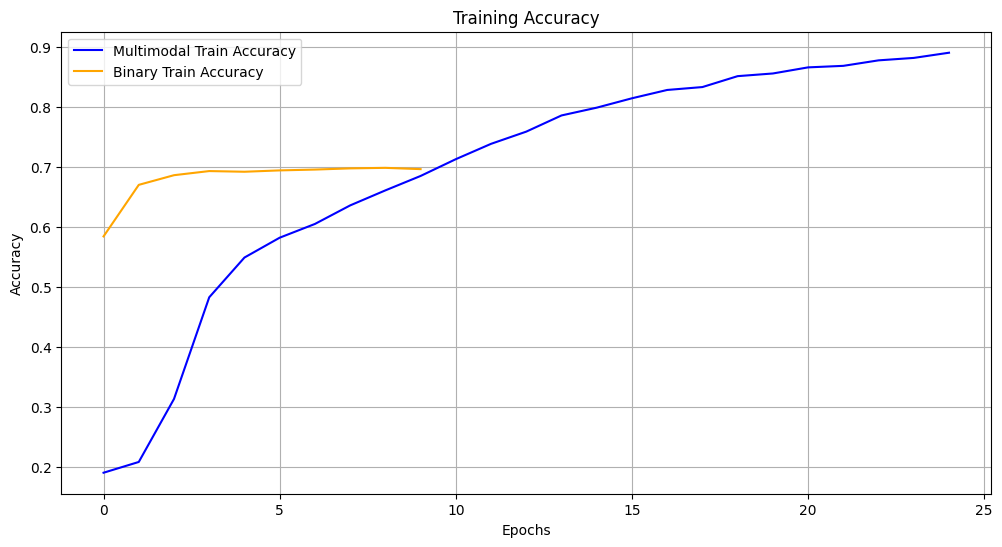

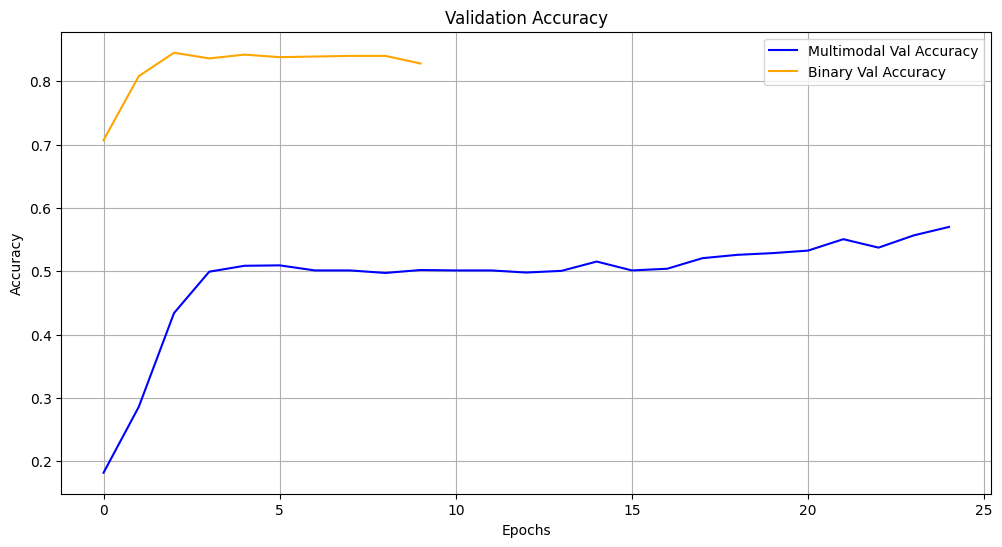

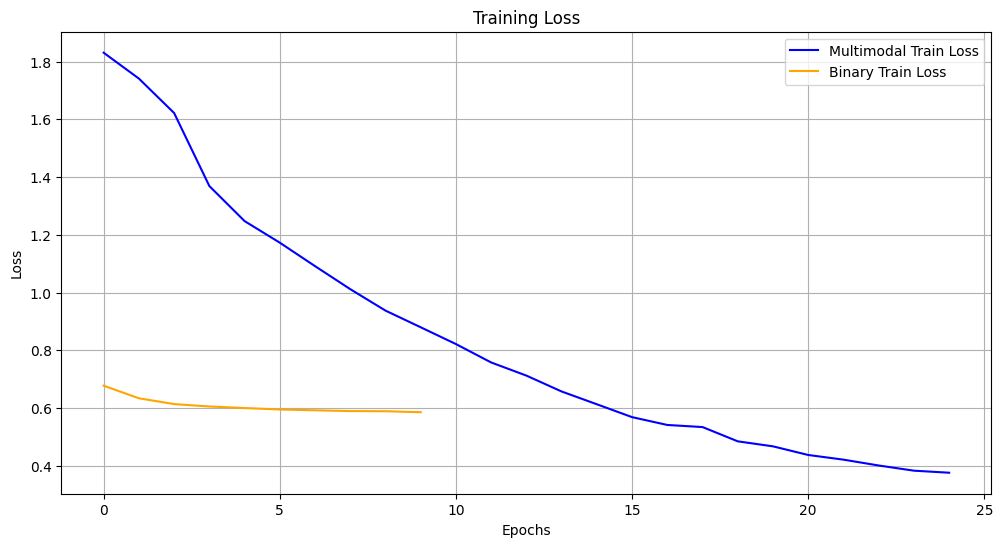

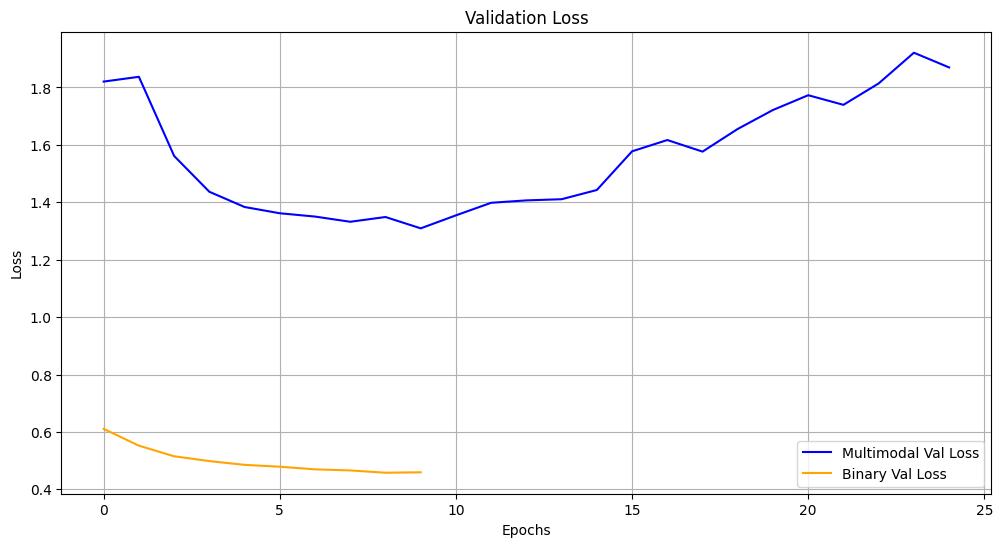

In [92]:
import matplotlib.pyplot as plt

# Training Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Multimodal Train Accuracy', color='blue')
plt.plot(history2.history['accuracy'], label='Binary Train Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_accuracy'], label='Multimodal Val Accuracy', color='blue')
plt.plot(history2.history['val_accuracy'], label='Binary Val Accuracy', color='orange')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Training Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Multimodal Train Loss', color='blue')
plt.plot(history2.history['loss'], label='Binary Train Loss', color='orange')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['val_loss'], label='Multimodal Val Loss', color='blue')
plt.plot(history2.history['val_loss'], label='Binary Val Loss', color='orange')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [93]:
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input


In [94]:
# Select 5 random indices from the entire dataset
random_indices = random.sample(range(len(df)), 5)

# Prepare the images and corresponding labels for visualization
images_to_show = []
true_labels = []
predicted_binary_labels = []
predicted_multimodal_labels = []

In [95]:
# Process images and get predictions
for idx in random_indices:
    # Get the image path from the dataset
    img_path = df['image_path'][idx]
    img = load_img(img_path, target_size=(224, 224))  # Resize image to fit model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension (1, 224, 224, 3)
    img_array = preprocess_input(img_array)  # Preprocessing for ResNet50

    # Preprocess the text using the tokenizer (convert text to sequence)
    text_sequence = tokenizer.texts_to_sequences([df['cleaned_text'][idx]])
    text_padded = pad_sequences(text_sequence, maxlen=100)  # Adjust `maxlen` based on your model's input length

    images_to_show.append(img)
    true_labels.append(df['majority_label_str'][idx])  # True labels from the dataset for multimodal model

    # Get binary model prediction (for binary classification)
    binary_prediction = binary_model.predict([img_array, text_padded])
    binary_predicted_label = (binary_prediction > 0.5).astype(int)  # Binary classification: 0 or 1
    predicted_binary_labels.append(binary_predicted_label[0][0])  # Extracting the actual value

    # Get multimodal model prediction (for multimodal classification)
    multimodal_prediction = multimodal_model.predict([img_array, text_padded])
    multimodal_predicted_label = np.argmax(multimodal_prediction, axis=1)  # Multi-class classification
    predicted_multimodal_labels.append(multimodal_predicted_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


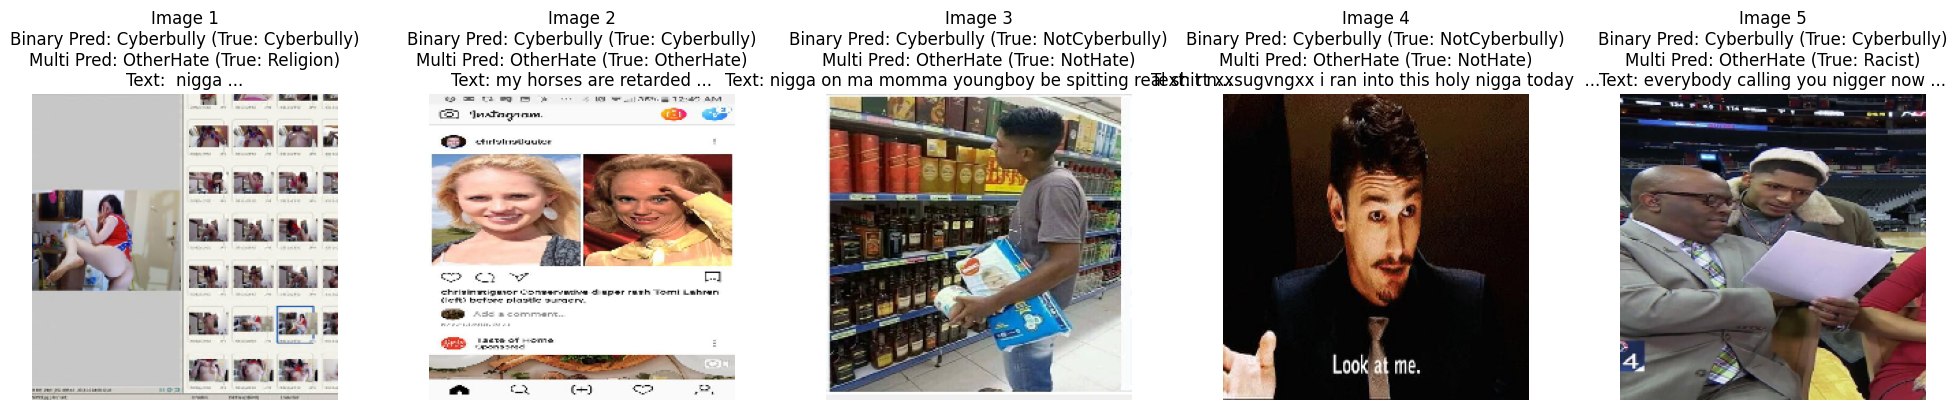

In [ ]:
# Create the figure for displaying images and predictions
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Label mappings for multimodal and binary models
multimodal_label_mapping = {
    0: "NotHate",
    1: "Racist",
    2: "Sexist",
    3: "Homophobe",
    4: "Religion",
    5: "OtherHate"
}

binary_label_mapping = {
    0: "NotCyberbully",
    1: "Cyberbully"
}

# Display images with their predictions from both models
for i, ax in enumerate(axes):
    ax.imshow(images_to_show[i])
    ax.axis('off')

    # Get the true label strings (from dataset)
    true_binary_label_str = binary_label_mapping[df['binary_label'][i]]  # Actual label for binary model
    true_multimodal_label_str = multimodal_label_mapping[df['majority_label'][i]]  # Actual label for multimodal model
    text_data = df['cleaned_text'][i]  # Text data corresponding to the image

    # Get the predicted labels (from models)
    binary_predicted_label = int(predicted_binary_labels[i])  # Convert to integer scalar for binary model
    multimodal_predicted_label = int(predicted_multimodal_labels[i])  # Convert to integer scalar for multimodal model

    # Get predicted label strings
    binary_predicted_label_str = binary_label_mapping[binary_predicted_label]
    multimodal_predicted_label_str = multimodal_label_mapping[multimodal_predicted_label]

    # Display the results on the image
    ax.set_title(f"Image {i+1}\nBinary Pred: {binary_predicted_label_str} (True: {true_binary_label_str})\n"
                 f"Multi Pred: {multimodal_predicted_label_str} (True: {true_multimodal_label_str})\n"
                 f"Text: {text_data[:50]}...")  # Show first 50 characters of the text for brevity

plt.tight_layout()
plt.show()
